<a href="https://colab.research.google.com/github/Omars2003/HuggingFace/blob/main/Resumen_en_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
!pip install datasets #para este modelo ocuparemos Amazon_reviews we only will use english and spanish

In [5]:
from datasets import load_dataset



In [ ]:
spanish_dataset = load_dataset("amazon_reviews_multi", "es")
english_dataset = load_dataset("amazon_reviews_multi", "en")


In [ ]:
english_dataset 

we are interested in is contained in the review_body and review_title columns

In [7]:
def muestra_ejemplos(dataset, num_samples=4, seed=50):#seed=un grupo de 50
    ejemplos = dataset["train"].shuffle(seed=seed).select(range(num_samples)) #shuffle funtion cambia el orden 
    for example in ejemplos:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


muestra_ejemplos(english_dataset)
muestra_ejemplos(spanish_dataset)


'>> Title: Dont order in winter'
'>> Review: I thought these would look cool and they arrived in OK condition. Here is where I have issues being a first time cactus buyer: these should have come potted at this price / Seller should not ship in the coldest parts of winter. They arrived looking a little roughed up and shortly died because they froze during delivery or on my front porch while I was at work. Probably a good product if it didn't freeze.'

'>> Title: Runs big in my opinion'
'>> Review: Haven't looked into return policy but would return as the size is too big. It works as it says and you will sweat in your mid section. Great concept just wish I could return for smaller size.'

'>> Title: Doesn't work for iPhone 8'
'>> Review: This does not work for an iPhone 8.'

'>> Title: Unless you have darker very tan skin I recommend the translucent (white) color instead of cool beige but ...'
'>> Review: Unless you have darker very tan skin I recommend the translucent (white) color ins

 Training a summarization model on all 400,000 reviews would take far too long on a single GPU, so instead we’ll focus on generating summaries for a single domain of products.

To get a feel for what domains we can choose from, let’s convert english_dataset to a pandas.DataFrame and compute the number of reviews per product category:

In [ ]:
english_dataset.set_format("arrow") #arrow or #pandas
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

we are going to use the books and e-books reviews, so we need to separate their reviews.

Now when we apply this function to english_dataset and spanish_dataset, the result will contain just those rows involving the book categories. Before applying the filter, let’s switch the format of english_dataset from "pandas" back to "arrow":

In [9]:
def filtros_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

In [10]:
english_dataset.reset_format()
spanish_dataset.reset_format()

In [ ]:
spanish_books = spanish_dataset.filter(filtros_books)
english_books = english_dataset.filter(filtros_books)
muestra_ejemplos(english_books)
muestra_ejemplos(spanish_books)

WE HAVE a last step about data and itscombining the English and Spanish reviews as a single DatasetDict objec

Concatenate_datasets() function that (as the name suggests) will stack two Dataset objects on top of each other. So, to create our bilingual dataset, we’ll loop over each split, concatenate the datasets for that split, and shuffle the result to ensure our model doesn’t overfit to a single language:

In [12]:
from datasets import concatenate_datasets, DatasetDict

books_dataset = DatasetDict()

In [13]:
for split in english_books.keys():
    books_dataset[split] = concatenate_datasets(
        [english_books[split], spanish_books[split]]
    )
    books_dataset[split] = books_dataset[split].shuffle(seed=50)

In [14]:
muestra_ejemplos(books_dataset)


'>> Title: Guía de luchadores exclusivamente'
'>> Review: Cuidado al comprar esta guía, puede no ser lo que imaginas. Toca exclusivamente los personajes, no habla ni de los entornos, ni del modo aventura, ni de estrategias con los espíritus... nada de nada, solo personajes. Lo que cuenta, lo cuenta bien, pero reitero que hay áreas enormes del juego que no toca. Para ser una guía oficial, es muy escasa.'

'>> Title: Useful.'
'>> Review: Great book, worth buying it.'

'>> Title: Fallo de amazon'
'>> Review: No me ha llegado. Paquete perdido. He pedido la anulación del pedido y no se nada todavía.'

'>> Title: Fácil lectura'
'>> Review: Mario ha conseguido mediante este libro basar en ejemplos y en reflexiones abiertas explicar de una manera simple las diferentes formas y retos que un líder debe conocer para mejorar su inteligencia emocional.'


para task como resumenes es importante checar que los titulos  las reseñas tengan mas d 2 dos palabras ya que esto puede afectar el task de un resumen dando como output pocas palabras ya que es asi como se esta entrenando los datos

por lo que vamos a filtrar los textos, para quitar los cortos y que demeos mejores resumenes!!!

In [15]:
books_dataset = books_dataset.filter(lambda x: len(x["review_title"].split()) > 2)

  0%|          | 0/18 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

APARTIR DE AQUI YA TENEMOS LOS DATOS SEPARADOS DE LA MANERA QUE QUEREMOS Y QUE VA A SER MAS EFICAZ PARA ASI PODER EMEPZAR A USAR UN MODELO PARA NUESTRO TASK !!!
WUUUUUU

Transformer models for summarization adopt the encoder-decoder architecture
We’ll focus on mT5, an interesting architecture based on T5 that was pretrained in a text-to-text framework. In T5, every NLP task is formulated in terms of a prompt prefix like summarize: which conditions the model to adapt the generated text to the prompt. As shown in the figure below, this makes T5 extremely versatile, as you can solve many tasks with a single model!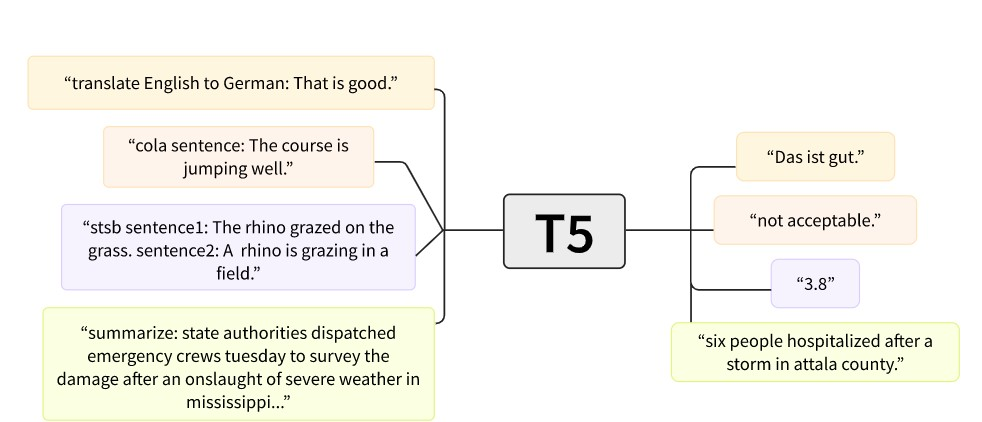

In [16]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [17]:
input=tokenizer("I have finished How the world really works")
input


{'input_ids': [336, 783, 259, 47149, 5100, 287, 4836, 259, 4940, 19514, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokenizer.convert_ids_to_tokens(input.input_ids)

['▁I',
 '▁have',
 '▁',
 'finished',
 '▁How',
 '▁the',
 '▁world',
 '▁',
 'really',
 '▁works',
 '</s>']

Unigram is especially useful for multilingual corpora since it allows SentencePiece to be agnostic about accents, punctuation, and the fact that many languages, like Japanese, do not have whitespace characters.

In [19]:
max_input_length = 512
max_target_length = 30
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["review_body"], max_length=max_input_length, truncation=True
    )
    # Set up the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["review_title"], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
    

as_target_tokenizer() function that allows you to tokenize the labels in parallel to the inputs. This is typically done using a context manager inside a preprocessing function that first encodes the inputs, and then encodes the labels as a separate column

Let’s walk through this code to understand what’s happening. The first thing we’ve done is define values for max_input_length and max_target_length, which set the upper limits for how long our reviews and titles can be. Since the review body is typically much larger than the title, we’ve scaled these values accordingly. Then, in the preprocess_function() itself we can see the reviews are first tokenized, followed by the titles with as_target_tokenizer().

With preprocess_function(), it is then a simple matter to tokenize the whole corpus using the handy Dataset.map() function we’ve used extensively throughout this course:

In [20]:
tokenized_datasets = books_dataset.map(preprocess_function, batched=True) #aqui ya se tokeniza titulo y cuerpo a la par de todo el dataset de books, y se rellenan con el batch
tokenized_datasets

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 9672
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 238
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 245
    })
})

In [ ]:
#lets put metrics to our model(this depends now on how we want our model to work)

In [ ]:
# we will use ROUGE metrics which compares  a summary against a set of references created by humans


In [25]:
generated_summary = "realmente me gusta mucho leer"
reference_summary = "me gusta mucho leer"
#d ROUGE is based on computing the precision and recall scores for the overlap.
#Recall= Totalnumberofwords /  inreferencesummaryNumberofoverlappingwords #el numero de palabras que son las mismas entre si 
#Precision= Totalnumberofwordsingeneratedsummary/ Numberofoverlappingwords #el numero de palabras que hay en las de referencia sobre las que nuestro modelo genero.

para hacer eso en el programa instalamos:

In [21]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=d170c09f01fffa1957f034c18807058c6a150cdc1eb20e4604d7af9a2fc08a73
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [ ]:
#we import rouge metrics as
!pip install evaluate

In [ ]:
import evaluate
rouge_score = evaluate.load("rouge")


In [26]:
scores = rouge_score.compute(
    predictions=[generated_summary], references=[reference_summary]
)
scores

{'rouge1': 0.888888888888889,
 'rouge2': 0.8571428571428571,
 'rougeL': 0.888888888888889,
 'rougeLsum': 0.888888888888889}

rouge2 measures the overlap between bigrams (think the overlap of pairs of words), while rougeL and rougeLsum measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The “sum” in rougeLsum refers to the fact that this metric is computed over a whole summary, while rougeL is computed as the average over individual sentences.

In [27]:
!pip install nltk

In [28]:
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [51]:
from nltk.tokenize import sent_tokenize


def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])


print(three_sentence_summary(books_dataset["train"][6]["review_body"]))

Como todo lo de esta autora, buena narración, argumento y desarrollo.
Repetiré seguro con.


In [1]:
def evaluate_baseline(dataset, metric):#Something, such as a set of data, used as a basis for comparison or as a control in a study
    summaries = [three_sentence_summary(text) for text in dataset["review_body"]]
    return metric.compute(predictions=summaries, references=dataset["review_title"])

We can then use this function to compute the ROUGE scores over the validation set and prettify them a bit using Pandas:

In [35]:
import pandas as pd
rouge_dict=[]
score = evaluate_baseline(books_dataset["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 16.11, 'rouge2': 8.46, 'rougeL': 14.81, 'rougeLsum': 15.34}

now we have tu fine-tune our model,so we use a sequence-to-sequence task, we can load the model with the AutoModelForSeq2SeqLM class, which will automatically download and cache the weights:
s2s task is use in summarization tasks!

In [36]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

We’ll need to generate summaries in order to compute ROUGE scores during training. Fortunately, 🤗 Transformers provides dedicated Seq2SeqTrainingArguments and Seq2SeqTrainer classes that can do this for us automatically! To see how this works, let’s first define the hyperparameters and other arguments for our experiments:

In [49]:
from transformers import Seq2SeqTrainingArguments

batch_size = 8
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-amazon-en-es",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5, # que tan rapido aprende nuestro modelo de IA
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3, #option to only save up to 3 checkpoints during training 
    num_train_epochs=num_train_epochs,
    predict_with_generate=True, #generate summaries during evaluation so that we can compute ROUGE scores for each epoch
    logging_steps=logging_steps,
    push_to_hub=True,
)

The next thing we need to do is provide the trainer with a compute_metrics() function so that we can evaluate our model during training. For summarization this is a bit more involved than simply calling rouge_score.compute() on the model’s predictions, since we need to decode the outputs and labels into text before we can compute the ROUGE scores. The following function does exactly that, and also makes use of the sent_tokenize() function from nltk to separate the summary sentences with newlines:

In [40]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

Next, we need to define a data collator for our sequence-to-sequence task. Since mT5 is an encoder-decoder Transformer model, one subtlety with preparing our batches is that during decoding we need to shift the labels to the right by one. This is required to ensure that the decoder only sees the previous ground truth labels and not the current or future ones, which would be easy for the model to memorize. This is similar to how masked self-attention is applied to the inputs in a task like causal language modeling.

Luckily, 🤗 Transformers provides a DataCollatorForSeq2Seq collator that will dynamically pad the inputs and the labels for us. To instantiate this collator, we simply need to provide the tokenizer and model:

Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

To be able to build batches, data collators may apply some processing (like padding). Some of them (like DataCollatorForLanguageModeling) also apply some random data augmentation (like random masking) on the formed batch.

Examples of use can be found in the example scripts or example notebooks.

In [55]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [56]:
features = [tokenized_datasets["train"][i] for i in range(2)]
data_collator(features)

{'input_ids': tensor([[  1124,    416,    560,  16409,    537,    259,    262,   7581,    375,
            707,    790,    259,  80163,    261,    362,  20591,    707,    259,
         233471,    269,  89667,    265,    259,  24427,    259,   7271,  18669,
            268,    289,  20513,    259,    276,    303,    707,  39589,    265,
            259,    262,    658,  14988,    319,    655,   2769,    269,   1797,
            260,   4295,    259,   7239,    510,    417,    269,    573,    674,
           1194,    259,    276,    416,  40086,    272,    259,    276,    362,
          11393,    655,    283,    283,   3742,    261,    416,  40086,    261,
           4955,   1411,   1796,    260,      1],
        [   298,   1834,   7509,    337,    520,  90444,    553,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,     

Let’s see what this collator produces when fed a small batch of examples. First, we need to remove the columns with strings because the collator won’t know how to pad these elements, ya viene por default con las nuevas actulizaciones.
Since the collator expects a list of dicts, where each dict represents a single example in the dataset, we also need to wrangle the data into the expected format before passing it to the data collator:
The main thing to notice here is that the first example is longer than the second one, so the input_ids and attention_mask of the second example have been padded on the right with a [PAD] token (whose ID is 0). Similarly, we can see that the labels have been padded with -100s, to make sure the padding tokens are ignored by the loss function. And finally, we can see a new decoder_input_ids which has shifted the labels to the right by inserting a [PAD] token in the first entry.

In [58]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [59]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/OMARS200/mt5-small-finetuned-amazon-en-es into local empty directory.


In [1]:

trainer.train()

NameError: ignored

In [ ]:
trainer.evaluate()

During training, you should see the training loss decrease and the ROUGE scores increase with each epoch. Once the training is complete, you can see the final ROUGE scores by running Trainer.evaluate():

Copied
trainer.evaluate()